# **Detecting Fake News Using Machine Learning Algorithms**

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import spacy
import statistics
from collections import Counter
import sklearn

# **Data Preparation**

In [2]:
# import the data in pandas dataframes
fake_news = pd.read_csv('../input/fake-and-real-news-dataset/Fake.csv')
real_news = pd.read_csv('../input/fake-and-real-news-dataset/True.csv')

# create a new column with the class of each article in the dataset
fake_news["label"] = "fake"
real_news["label"] = "real"

# print dataset sizes
print("\nDataset Sizes:")
print (f"Fake News: {fake_news.shape}")
print (f"Real News: {real_news.shape}")


Dataset Sizes:
Fake News: (23481, 5)
Real News: (21417, 5)


In [3]:
# Remove location and publisher columns from real news dataframe for consistency with the fake news dataframe
real_news["text"] = real_news['text'].apply(lambda x: x.partition("-")[2])

# Display the subjects included in the dataset.
print (fake_news["subject"].unique())
print (real_news["subject"].unique())

# Remove articles with only pictures or no text at all
real_news = real_news[real_news["text"] != ""] 
fake_news = fake_news[fake_news["text"] != ""] 

# Print dataset sizes
print("\nDataset Sizes:")
print(f"Fake News: {fake_news.shape}")
print(f"Real News: {real_news.shape}")

print()

# Save the prepared dataset to .csv files
fake_news.to_csv('fakeForModeling.csv')
#!cp fakeForModeling.csv "./"
real_news.to_csv('trueForModeling.csv')
#!cp trueForModeling.csv "./"

['News' 'politics' 'Government News' 'left-news' 'US_News' 'Middle-east']
['politicsNews' 'worldnews']

Dataset Sizes:
Fake News: (23481, 5)
Real News: (21415, 5)



# **Data Cleansing And Pre-Processing**

In [4]:
import string
import nltk
# nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
import requests

stop_words = list(stopwords.words('english'))
#additional stopwords
stop_words.extend(["said", "reuters", "CNN", "image", "via", 'monday', 'tuesday', 'wednesday', 'thursday', 'friday']) 
# opening the file in read mode
extra_stopwords_file = open("../input/stopwords/stopwords-en.txt", "r")
# reading the file
extra_stopwords = extra_stopwords_file.read()
# replacing end splitting the text when newline ('\n') is seen.
extra_stopwords_list = extra_stopwords.split("\n")
# closing the file
extra_stopwords_file.close()
# appending the list of stopwords
stop_words.extend(extra_stopwords_list)

# Initialize the lemmatization process
lemmatizer = WordNetLemmatizer()  

words_in_t = [] #all tokens in true articles
words_in_f = [] #all tokens in fake articles
words_in_each_article_t = [] #list of true articles, each in tokenized form
words_in_each_article_f = [] #list of fake articles, each in tokenized form

def tokenize(article):
    '''
    Transforms all words into tokens
    '''
    return word_tokenize(article)

def to_lower_case(words):
    '''
    Transforms all words to lower case
    '''
    return [word.lower() for word in words if word.isalpha()]

def remove_stopwords_punctuation(words):
    '''
    Removes stopwords and punctuation from the dataset
    '''
    return [word for word in words if word not in string.punctuation and word not in stop_words]

def lemmatize(words):
    '''
    Converts a word to its root form, a lemma
    '''
    return [lemmatizer.lemmatize(word) for word in words]

def process(df, word_list, by_article_list):
    '''
    Executes cleansing and preprocessing for each article in the dataset
    '''
    for article in (df["text"]):
        words = tokenize(article)
        words = to_lower_case(words)
        words = remove_stopwords_punctuation(words)
        words = lemmatize(words)

        by_article_list.append(words)
        for w in words:
          word_list.append(w)

In [5]:
# Execute cleansing and preprocessing
process(fake_news, words_in_f, words_in_each_article_f)
process(real_news, words_in_t, words_in_each_article_t)

**Data Split Into Training And Test Set**

In [6]:
import sklearn.model_selection as ms
from sklearn.feature_extraction.text import TfidfVectorizer

# Get tokenized forms of all articles (true and fake) in one dataframe (X)
tokenised_dataset = []
for a in words_in_each_article_t:
  tokenised_dataset.append(a)
for b in words_in_each_article_f:
  tokenised_dataset.append(b)

# Get labels of all articles (true and fake) in one dataframe (y)
y = pd.concat([real_news["label"], fake_news["label"]])
y = [1 if x == "fake" else 0 for x in y] #1 and 0 for ease of tokenizing
articles = pd.DataFrame(tokenised_dataset)
labels = pd.DataFrame(y, columns=["label"])

# Save articles dataframe to .csv file
articles.to_csv('articles.csv')

# Save labels dataframe to .csv file
labels.to_csv('labels.csv')

# Split the data, 80% for the training set and 20% for the test set 
X_train, X_test, y_train, y_test = ms.train_test_split(tokenised_dataset, labels, test_size = 0.2, random_state=1)

# Keep all words that appear in more than the 10% of the documents in the dataset.
# Override the preprocessor in order to use the already cleansed words from the earlier phases.
tfidf = TfidfVectorizer(min_df = 0.1, preprocessor = ' '.join)

# Training Set
# Sparse Document-Term Matrix
response_train = tfidf.fit_transform(X_train) 
feature_names_train = tfidf.get_feature_names()

# Dense Document-Term Matrix
dense_train = response_train.todense() 
denselist_train = dense_train.tolist()
df_train = pd.DataFrame(denselist_train, columns=feature_names_train)

tfidf = TfidfVectorizer(preprocessor = ' '.join, vocabulary = feature_names_train)

# Test Set
# Sparse Document-Term Matrix
response_test = tfidf.fit_transform(X_test)
feature_names_test = tfidf.get_feature_names()

# Dense Document-Term Matrix
dense_test = response_test.todense() 
denselist_test = dense_test.tolist()
df_test = pd.DataFrame(denselist_test, columns=feature_names_test)

In [7]:
# Final data to be used for training models
df_train.to_csv('training_data.csv')

# Final data to be used for testing models
df_test.to_csv('testing_data.csv')

y_train = pd.DataFrame(y_train, columns=["label"])
y_test = pd.DataFrame(y_test, columns=["label"])

# Final labels to be used for training models
y_train.to_csv('train_labels.csv')

# Final labels to be used for testing models
y_test.to_csv('test_labels.csv')

# **Data Mining Phase I: *Detecting Fake News***

In [8]:
# import the required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import sklearn
from sklearn import metrics
from sklearn.metrics import mean_squared_error
import os

In [9]:
# load the preprocessed data for classification
# x_train = pd.read_csv('../input/fakereal-news-dataset-after-preprocessing/training_data.csv')
# x_test = pd.read_csv('../input/fakereal-news-dataset-after-preprocessing/testing_data.csv')
# y_train = pd.read_csv('../input/fakereal-news-dataset-after-preprocessing/train_labels.csv')
# y_test = pd.read_csv('../input/fakereal-news-dataset-after-preprocessing/test_labels.csv')

x_train = df_train
x_test = df_test

fake = pd.read_csv('./fakeForModeling.csv')
true = pd.read_csv('./trueForModeling.csv')

# print dataset sizes
print("\nDataset Sizes:")
print (f"Fake News: {fake.shape}")
print (f"Real News: {true.shape}")


Dataset Sizes:
Fake News: (23481, 6)
Real News: (21415, 6)


In [10]:
# Saving Models Utilities
import pickle

def save_model(model, filename_with_ext):
    '''
    Saves a machine learning model produced using sci-kit learn in a .pkl file.
    '''  
    with open(filename_with_ext, 'wb') as file:  
        pickle.dump(model, file)
    print("\nThe model was saved successfully.")

**Naive Bayes**

CPU times: user 20.6 ms, sys: 1.9 ms, total: 22.5 ms
Wall time: 20.6 ms

Accuracy is: 0.8249443207126949
Mean Squared Error is: 0.41839655745154636

Naive Bayes Confusion Matrix: 



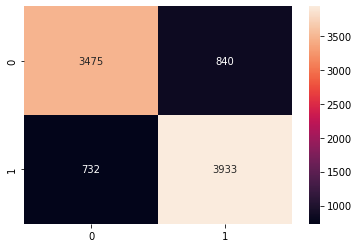


Naive Bayes Classification Report: 

              precision    recall  f1-score   support

           0       0.83      0.81      0.82      4315
           1       0.82      0.84      0.83      4665

    accuracy                           0.82      8980
   macro avg       0.83      0.82      0.82      8980
weighted avg       0.82      0.82      0.82      8980


The model was saved successfully.

Naive Bayes AUC Score:  0.8948953959305944

Receiver Operating Characteristic (ROC) Curve: 



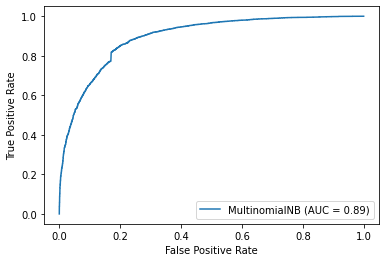

In [11]:
from nltk import NaiveBayesClassifier
from sklearn.naive_bayes import MultinomialNB

# Load classifier
nb = MultinomialNB()# one of the two classic naive Bayes variants used in text classification

# Train classifier
%time nb.fit(x_train, np.ravel(y_train))

# Test classifier
y_pred_class = nb.predict(x_test)

# Calculate perfomance metrics
print("\nAccuracy is:", metrics.accuracy_score(y_test, y_pred_class))
print("Mean Squared Error is:", np.sqrt(mean_squared_error(y_test, y_pred_class)))

# Display confusion matrix
nb_cm = metrics.confusion_matrix(y_test, y_pred_class)
print("\nNaive Bayes Confusion Matrix: \n")
labels =  np.array([[nb_cm[0,0],nb_cm[0,1]],[nb_cm[1,0],nb_cm[1,1]]])
sns.heatmap(nb_cm, annot=labels, fmt = '')
plt.show()

# Display classification report
print("\nNaive Bayes Classification Report: \n")
print(metrics.classification_report(y_test, y_pred_class))

# Save Model
save_model(nb, "naive_bayes.pkl")

# Calculate predicted probabilities for test data 
y_pred_prob_nb = nb.predict_proba(x_test)[:, 1]

# Calculate AUC Score
print("\nNaive Bayes AUC Score: ", metrics.roc_auc_score(y_test, y_pred_prob_nb))

# Plot ROC curve
print("\nReceiver Operating Characteristic (ROC) Curve: \n")
metrics.plot_roc_curve(nb, x_test, y_test)

In [12]:
#Number of times token appears in each True article
true_token = nb.feature_count_[0, :]

#Number of times token appears in each Fake article
fake_token = nb.feature_count_[1, :]
tokens = pd.DataFrame({'token':x_train.columns, 'true':true_token, 'fake':fake_token}).set_index('token')

# add 1 to true and fake counts to avoid dividing by 0
tokens['true'] = tokens.true + 1
tokens['fake'] = tokens.fake + 1
# convert the true and fake counts into frequencies
tokens['true'] = tokens.true / nb.class_count_[0]
tokens['fake'] = tokens.fake / nb.class_count_[1]
# calculate the ratio of fake to true for each token
tokens['fake/true ratio'] = tokens.fake / tokens.true
print("Top 10 most frequently occuring words in the data by : \n")
tokens.sort_values('fake/true ratio', ascending=False).head(10)

Top 10 most frequently occuring words in the data by : 



,true,fake,fake/true ratio
token,,,
video,0.005882,0.053897,9.163735
hillary,0.010566,0.060571,5.732512
story,0.006141,0.030931,5.037121
america,0.010149,0.049432,4.870788
life,0.010415,0.035045,3.364871
woman,0.016352,0.054987,3.362762
american,0.024181,0.059569,2.463421
clinton,0.029581,0.069832,2.360716
matter,0.010605,0.024365,2.297606


**Support Vector Machines**

Accuracy is: 0.8570155902004455
Mean Squared Error is: 0.37813279386950105

Support Vector Machines Confusion Matrix: 



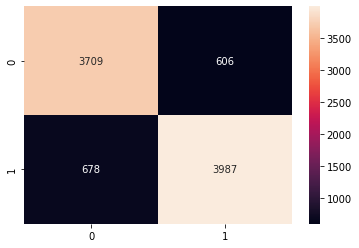


Support Vector Machines Classification Report: 

              precision    recall  f1-score   support

           0       0.85      0.86      0.85      4315
           1       0.87      0.85      0.86      4665

    accuracy                           0.86      8980
   macro avg       0.86      0.86      0.86      8980
weighted avg       0.86      0.86      0.86      8980


The model was saved successfully.

Support Vector Machines AUC Score:  0.8571110274858138

Receiver Operating Characteristic (ROC) Curve: 



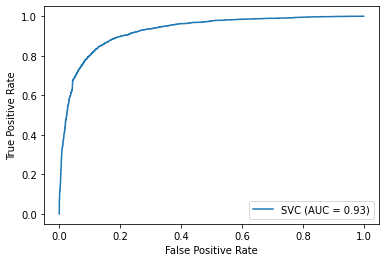

In [13]:
from sklearn.svm import SVC

# Load classifier
svc = SVC(kernel='linear', random_state=1) 

# Train classifier
svc.fit(x_train, np.ravel(y_train))

# Test classifier
y_pred_svm = svc.predict(x_test)

# Calculate performance metrics
print("Accuracy is:", metrics.accuracy_score(y_test, y_pred_svm))
print("Mean Squared Error is:", np.sqrt(mean_squared_error(y_test, y_pred_svm)))

# Display confusion matrix
svm_cm = metrics.confusion_matrix(y_test, y_pred_svm)
print("\nSupport Vector Machines Confusion Matrix: \n")
labels =  np.array([[svm_cm[0,0],svm_cm[0,1]],[svm_cm[1,0],svm_cm[1,1]]])
sns.heatmap(svm_cm, annot=labels, fmt = '')
plt.show()

# Display classification report
print("\nSupport Vector Machines Classification Report: \n")
print(metrics.classification_report(y_test, y_pred_svm))

# Save Model
save_model(svc, "support_vector_machines.pkl")

# Calculate AUC Score
print ("\nSupport Vector Machines AUC Score: ", metrics.roc_auc_score(y_test, y_pred_svm))

# Plot ROC curve
print("\nReceiver Operating Characteristic (ROC) Curve: \n")
metrics.plot_roc_curve(svc, x_test, y_test)


**Random Forest**

CPU times: user 42 µs, sys: 1 µs, total: 43 µs
Wall time: 45.3 µs
Accuracy: 0.921380846325167
Mean Squared Error: 0.2803910727445383

Random Forest Confusion Matrix: 



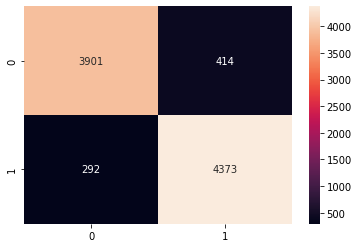


Random Forest Classification Report: 

              precision    recall  f1-score   support

           0       0.93      0.90      0.92      4315
           1       0.91      0.94      0.93      4665

    accuracy                           0.92      8980
   macro avg       0.92      0.92      0.92      8980
weighted avg       0.92      0.92      0.92      8980


The model was saved successfully.

Random Forest AUC Score:  0.9759400580492041

Display the top 10 most important features: 



<AxesSubplot:>

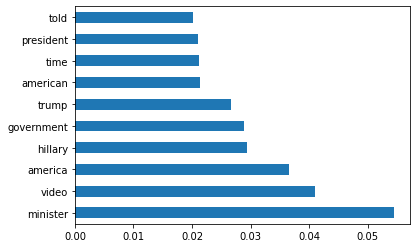

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Load classifier
rf = RandomForestClassifier(random_state = 1)

# Configure its parameters
param_grid = {
    'n_estimators': [200],
    'max_depth': [50, 60, 70]
    }

# Train classifier
%time grid_search_rf = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 5)
grid_search_rf.fit(x_train, np.ravel(y_train))
grid_search_rf.best_params_

# Test classifier
y_pred_rf = grid_search_rf.predict(x_test)

# Calculate perfomance metrics
print("Accuracy:", metrics.accuracy_score(y_test, y_pred_rf))
print("Mean Squared Error:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))

# Display confusion matrix
print("\nRandom Forest Confusion Matrix: \n")
rf_cm = metrics.confusion_matrix(y_test, y_pred_rf)
labels =  np.array([[rf_cm[0,0],rf_cm[0,1]],[rf_cm[1,0],rf_cm[1,1]]])
sns.heatmap(rf_cm, annot=labels, fmt = '')
plt.show()

# Display classification report
print("\nRandom Forest Classification Report: \n")
print(metrics.classification_report(y_test, y_pred_rf))

# Calculate predicted probabilities for test data 
y_pred_prob_rf = grid_search_rf.predict_proba(x_test)[:, 1]

# Save Model
save_model(rf, "random_forests.pkl")

# Calculate AUC Score
print("\nRandom Forest AUC Score: ", metrics.roc_auc_score(y_test, y_pred_prob_rf))

# Calculate and display feature importance
print("\nDisplay the top 10 most important features: \n")
feature_importances = pd.Series(grid_search_rf.best_estimator_.feature_importances_, index=x_train.columns)
feature_importances.nlargest(10).plot(kind='barh')



**Binomial Logistic Regression**

Accuracy is:  0.8557906458797327
Mean Squared Error is: 0.3797490673066456

Binomial Logistic Regression - Confusion Matrix: 



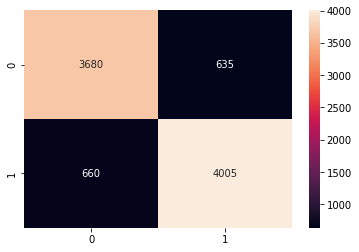


Binomial Logistic Regression - Classification Report: 
              precision    recall  f1-score   support

           0       0.85      0.85      0.85      4315
           1       0.86      0.86      0.86      4665

    accuracy                           0.86      8980
   macro avg       0.86      0.86      0.86      8980
weighted avg       0.86      0.86      0.86      8980


The model was saved successfully.

Binomial Logistic Regression - AUC Score: 

Receiver Operating Characteristic (ROC) Curve: 



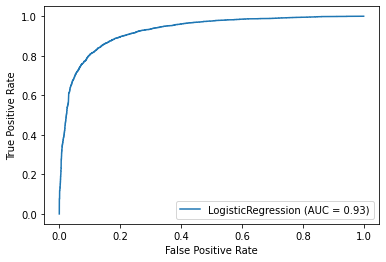

In [15]:
from sklearn.linear_model import LogisticRegression

# Load classifier
lr = LogisticRegression()

# Train classifier
lr.fit(x_train, np.ravel(y_train))

# Test classifier
y_pred_lr = lr.predict(x_test)

# Calculate performance metrics
print ("Accuracy is: ", metrics.accuracy_score(y_test, y_pred_lr))
print("Mean Squared Error is:", np.sqrt(mean_squared_error(y_test, y_pred_lr)))

# Display confusion matrix
lr_cm = metrics.confusion_matrix(y_test, y_pred_lr)
print("\nBinomial Logistic Regression - Confusion Matrix: \n")
labels =  np.array([[lr_cm[0,0],lr_cm[0,1]],[lr_cm[1,0],lr_cm[1,1]]])
sns.heatmap(lr_cm, annot=labels, fmt = '')
plt.show()

# Display classification report
print("\nBinomial Logistic Regression - Classification Report: ")
print(metrics.classification_report(y_test, y_pred_lr))

# Save Binomial Logistic Regression Model
save_model(lr, "binomial_logistic_regression.pkl")

# Calculate predicted probabilities for test data 
y_pred_prob_lr = lr.predict_proba(x_test)[:, 1]

# Calculate AUC Score 
print("\nBinomial Logistic Regression - AUC Score: ")
metrics.roc_auc_score(y_test, y_pred_prob_lr)

# Plot ROC curve
print("\nReceiver Operating Characteristic (ROC) Curve: \n")
metrics.plot_roc_curve(lr, x_test, y_test)

**Decision Trees: CART**

Accuracy: 0.8479955456570156

Mean Squared Error: 0.38987748632485103


Decision Tree (CART) Confusion Matrix: 



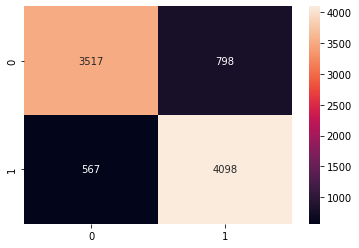


Decision Tree (CART) Classification Report: 

              precision    recall  f1-score   support

           0       0.86      0.82      0.84      4315
           1       0.84      0.88      0.86      4665

    accuracy                           0.85      8980
   macro avg       0.85      0.85      0.85      8980
weighted avg       0.85      0.85      0.85      8980


The model was saved successfully.
Decision Tree (CART) AUC Score: 0.8467601614051037

Receiver Operating Characteristic (ROC) Curve: 



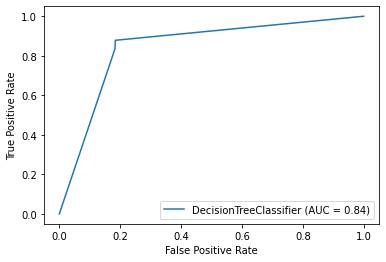

In [16]:
from sklearn import tree

# Load classifier
decision_tree = tree.DecisionTreeClassifier(criterion='entropy', random_state=4) # for these parameters the model performed better than having the default values.

# Train classifier
decision_tree.fit(x_train, np.ravel(y_train))

# Test the model
y_pred_dt = decision_tree.predict(x_test)

# Calculate performance metrics
print(f"Accuracy: {metrics.accuracy_score(y_test,y_pred_dt)}\n")
print(f"Mean Squared Error: {np.sqrt(mean_squared_error(y_test, y_pred_dt))}\n")

# Display confusion matrix
cart_cm = metrics.confusion_matrix(y_test,y_pred_dt)
print("\nDecision Tree (CART) Confusion Matrix: \n")
labels =  np.array([[cart_cm[0,0],cart_cm[0,1]],[cart_cm[1,0],cart_cm[1,1]]])
sns.heatmap(cart_cm, annot=labels, fmt = '')
plt.show()

# Display classification report
print("\nDecision Tree (CART) Classification Report: \n")
print(metrics.classification_report(y_test,y_pred_dt))

# Save decision tree CART model
save_model(decision_tree, "decision_tree_cart.pkl")

# Calculate AUC Score
print(f"Decision Tree (CART) AUC Score: {metrics.roc_auc_score(y_test, y_pred_dt)}")

# Plot ROC curve
print("\nReceiver Operating Characteristic (ROC) Curve: \n")
metrics.plot_roc_curve(decision_tree, x_test, y_test)

**k Nearest Neighbors**

Accuracy: 0.8815144766146993

Mean Squared Error: 0.3442172618932709


Confusion Matrix: 



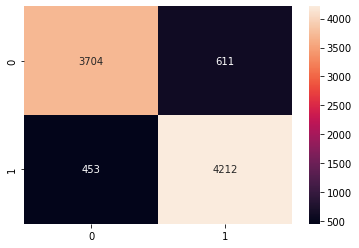


Classification Report: 

              precision    recall  f1-score   support

           0       0.89      0.86      0.87      4315
           1       0.87      0.90      0.89      4665

    accuracy                           0.88      8980
   macro avg       0.88      0.88      0.88      8980
weighted avg       0.88      0.88      0.88      8980


The model was saved successfully.
k Nearest Neighbors AUC Score: 0.8806474088370413

Receiver Operating Characteristic (ROC) Curve: 



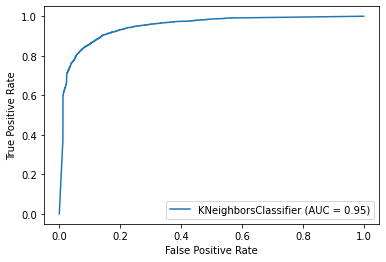

In [17]:
from sklearn.neighbors import KNeighborsClassifier

# Load classifier
n_neighbors = 8
knn = KNeighborsClassifier(n_neighbors, weights='distance')

# Train classifier
knn.fit(x_train, np.ravel(y_train))

# Test the model
y_pred_knn = knn.predict(x_test)

# Calculate performance metrics
print(f"Accuracy: {metrics.accuracy_score(y_test,y_pred_knn)}\n")
print(f"Mean Squared Error: {np.sqrt(mean_squared_error(y_test, y_pred_knn))}\n")

# Display confusion matrix
knn_cm = metrics.confusion_matrix(y_test,y_pred_knn)
print("\nConfusion Matrix: \n")
labels =  np.array([[knn_cm[0,0],knn_cm[0,1]],[knn_cm[1,0],knn_cm[1,1]]])
sns.heatmap(knn_cm, annot=labels, fmt = '')
plt.show()

# Display classification report
print("\nClassification Report: \n")
print(metrics.classification_report(y_test,y_pred_knn))

# Save kNN model
save_model(knn, "kNN.pkl")

# Calculate AUC Score
print(f"k Nearest Neighbors AUC Score: {metrics.roc_auc_score(y_test, y_pred_knn)}")

# Plot ROC curve
print("\nReceiver Operating Characteristic (ROC) Curve: \n")
metrics.plot_roc_curve(knn, x_test, y_test)

**Passive Aggressive**

Accuracy: 0.837750556792873

Mean Squared Error: 0.4028019900734441


Passive Aggressive Confusion Matrix: 



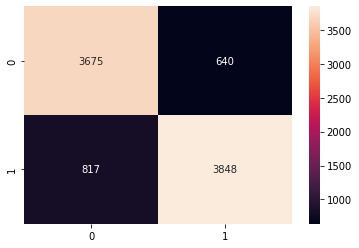


Passive Aggressive Classification Report: 

              precision    recall  f1-score   support

           0       0.82      0.85      0.83      4315
           1       0.86      0.82      0.84      4665

    accuracy                           0.84      8980
   macro avg       0.84      0.84      0.84      8980
weighted avg       0.84      0.84      0.84      8980


The model was saved successfully.

Passive Aggressive AUC Score: 0.838273104489809

Receiver Operating Characteristic (ROC) Curve: 



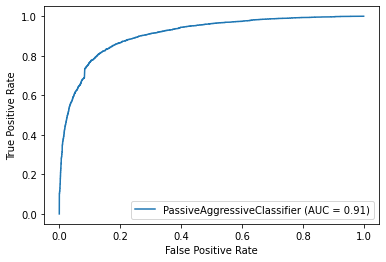

In [18]:
from sklearn.linear_model import PassiveAggressiveClassifier

# Load classifier
pac=PassiveAggressiveClassifier(max_iter=50)

# Train classifier
pac.fit(x_train,np.ravel(y_train))

# Test the model
y_pred_pac=pac.predict(x_test)

# Calculate performance metrics
print(f"Accuracy: {metrics.accuracy_score(y_test,y_pred_pac)}\n")
print(f"Mean Squared Error: {np.sqrt(mean_squared_error(y_test, y_pred_pac))}\n")

# Display confusion matrix
print("\nPassive Aggressive Confusion Matrix: \n")
pac_cm = metrics.confusion_matrix(y_test,y_pred_pac)
labels =  np.array([[pac_cm[0,0],pac_cm[0,1]],[pac_cm[1,0],pac_cm[1,1]]])
sns.heatmap(pac_cm, annot=labels, fmt = '')
plt.show()

# Display classification report
print("\nPassive Aggressive Classification Report: \n")
print(metrics.classification_report(y_test,y_pred_pac))

# Save model
save_model(pac, "pac.pkl")

# Calculate AUC Score
print(f"\nPassive Aggressive AUC Score: {metrics.roc_auc_score(y_test, y_pred_pac)}")

# Plot ROC curve
print("\nReceiver Operating Characteristic (ROC) Curve: \n")
metrics.plot_roc_curve(pac, x_test, y_test)

**AdaBoost** 

Using the default base estimator which is the CART Decision Tree classification algorithm.

Accuracy: 0.8776169265033408


AdaBoost Confusion Matrix: 



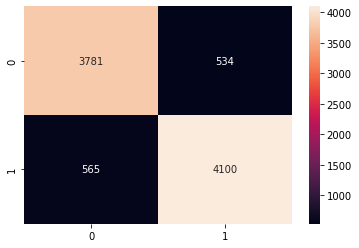


AdaBoost Classification Report: 

              precision    recall  f1-score   support

           0       0.87      0.88      0.87      4315
           1       0.88      0.88      0.88      4665

    accuracy                           0.88      8980
   macro avg       0.88      0.88      0.88      8980
weighted avg       0.88      0.88      0.88      8980


The model was saved successfully.
AdaBoost AUC Score: 0.8775654854386415

Receiver Operating Characteristic (ROC) Curve: 



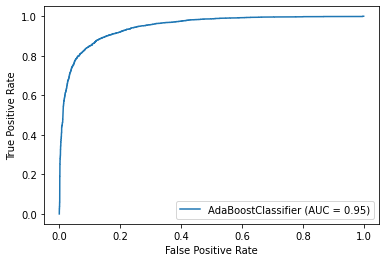

In [19]:
from sklearn.ensemble import AdaBoostClassifier

# Load classifier
adaboost = AdaBoostClassifier(n_estimators=850)

# Train classifier
adaboost.fit(x_train, np.ravel(y_train))

# Test the model
y_pred_ab = adaboost.predict(x_test)

# Calculate performance metrics
print(f"Accuracy: {metrics.accuracy_score(y_test,y_pred_ab)}\n")

# Display confusion matrix
ab_cm = metrics.confusion_matrix(y_test,y_pred_ab)
print("\nAdaBoost Confusion Matrix: \n")
labels =  np.array([[ab_cm[0,0],ab_cm[0,1]],[ab_cm[1,0],ab_cm[1,1]]])
sns.heatmap(ab_cm, annot=labels, fmt = '')
plt.show()

# Display classification report
print("\nAdaBoost Classification Report: \n")
print(metrics.classification_report(y_test,y_pred_ab))

# Save model
save_model(adaboost, "adaboost.pkl")

# Calculate Decision Tree AUC Score
print(f"AdaBoost AUC Score: {metrics.roc_auc_score(y_test, y_pred_ab)}")

# Plot ROC curve
print("\nReceiver Operating Characteristic (ROC) Curve: \n")
metrics.plot_roc_curve(adaboost, x_test, y_test)

# **Data Mining Phase II: *Topic Modelling***

**Latent Dirichlet Allocation (LDA)**

In [20]:
import gensim
import gensim.corpora as corpora
from pprint import pprint

# Set number of topics to predict
num_topics = 4

def get_lda_corpus(dataset):
    # Create Dictionary
    id2word = corpora.Dictionary(dataset)
    # Create Corpus
    articles = dataset
    # Term Document Frequency
    corpus = [id2word.doc2bow(article) for article in articles]
    # View
    print(corpus[:1][0][:30])
    return corpus, id2word

def build_lda(corpus, id2word, num_topics):
    # Build LDA model
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics)
    # Print the Keyword in the 10 topics
    pprint(lda_model.print_topics())
    return lda_model

def get_lda_topics(lda_model, corpus):
    doc_lda = lda_model[corpus]
    return doc_lda   


In [21]:
import pyLDAvis.gensim
import pickle 
import pyLDAvis

# Visualize the topics
def plot_topics(num_topics, lda_model, corpus, id2word):
    pyLDAvis.enable_notebook()
    LDAvis_data_filepath = os.path.join('./ldavis_prepared_'+str(num_topics))
    # # this is a bit time consuming - make the if statement True
    # # if you want to execute visualization prep yourself
    if 1 == 1:
        LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
        with open(LDAvis_data_filepath, 'wb') as f:
            pickle.dump(LDAvis_prepared, f)
    # load the pre-prepared pyLDAvis data from disk
    with open(LDAvis_data_filepath, 'rb') as f:
        LDAvis_prepared = pickle.load(f)
    pyLDAvis.save_html(LDAvis_prepared, './ldavis_prepared_'+ str(num_topics) +'.html')
    print(LDAvis_prepared)

/opt/conda/lib/python3.7/site-packages/past/types/oldstr.py:36: DeprecationWarning: invalid escape sequence \d
  """


In [22]:

def execute_lda(data):
    corpus = get_lda_corpus(data)[0]
    id2word = get_lda_corpus(data)[1]
    lda_model = build_lda(corpus, id2word, num_topics)
    doc_lda = get_lda_topics(lda_model, corpus)
    plot_topics(num_topics, lda_model, corpus, id2word)

# Perform LDA for fake news
execute_lda(words_in_each_article_f)

# Perform LDA for real news
execute_lda(words_in_each_article_t)

# open the generated html in a browser in order to see the displayed polts for the topic models

[(0, 1), (1, 1), (2, 3), (3, 2), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 2), (13, 1), (14, 1), (15, 1), (16, 2), (17, 1), (18, 1), (19, 13), (20, 1), (21, 1), (22, 1), (23, 1), (24, 3), (25, 3), (26, 1), (27, 5), (28, 1), (29, 3)]
[(0, 1), (1, 1), (2, 3), (3, 2), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 2), (13, 1), (14, 1), (15, 1), (16, 2), (17, 1), (18, 1), (19, 13), (20, 1), (21, 1), (22, 1), (23, 1), (24, 3), (25, 3), (26, 1), (27, 5), (28, 1), (29, 3)]
[(0,
  '0.031*"trump" + 0.011*"president" + 0.011*"clinton" + 0.010*"hillary" + '
  '0.008*"election" + 0.008*"donald" + 0.006*"republican" + 0.006*"obama" + '
  '0.006*"campaign" + 0.006*"party"'),
 (1,
  '0.009*"trump" + 0.007*"people" + 0.006*"medium" + 0.005*"black" + '
  '0.005*"white" + 0.004*"time" + 0.004*"student" + 0.004*"american" + '
  '0.004*"police" + 0.004*"president"'),
 (2,
  '0.005*"people" + 0.005*"american" + 0.005*"government" + 0.005*"obama" + '
  '0

/opt/conda/lib/python3.7/site-packages/pyLDAvis/_prepare.py:248: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.091776  0.025670       1        1  29.237510
2      0.052732 -0.037064       2        1  25.500144
1     -0.010249 -0.062961       3        1  25.303184
3      0.049292  0.074355       4        1  19.959161, topic_info=          Term          Freq         Total Category  logprob  loglift
97       trump  52355.000000  52355.000000  Default  30.0000  30.0000
123    clinton  22162.000000  22162.000000  Default  29.0000  29.0000
153    hillary  16974.000000  16974.000000  Default  28.0000  28.0000
148        fbi   5447.000000   5447.000000  Default  27.0000  27.0000
145   election  13097.000000  13097.000000  Default  26.0000  26.0000
...        ...           ...           ...      ...      ...      ...
895     public   2218.895869   7237.048371   Topic4  -5.8658   0.4293
1017      told   2170.382668   7890.495914   Topic4  -5.8879   0.3207
120

/opt/conda/lib/python3.7/site-packages/pyLDAvis/_prepare.py:248: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.061208  0.034949       1        1  31.869975
1      0.077274  0.049219       2        1  30.444793
3      0.047707 -0.063077       3        1  19.535821
2     -0.063773 -0.021091       4        1  18.149410, topic_info=            Term          Freq         Total Category  logprob  loglift
204        trump  40663.000000  40663.000000  Default  30.0000  30.0000
60      election  17597.000000  17597.000000  Default  29.0000  29.0000
139        party  26800.000000  26800.000000  Default  28.0000  28.0000
8743     myanmar   4556.000000   4556.000000  Default  27.0000  27.0000
167   republican  15286.000000  15286.000000  Default  26.0000  26.0000
...          ...           ...           ...      ...      ...      ...
197      support   1758.338408   8665.768746   Topic4  -5.9281   0.1115
128        month   1767.499375   9434.377279   Topic4  -5